In [1]:
from autolens import conf
from autolens.autofit import non_linear as nl
from autolens.pipeline import phase as ph
from autolens.imaging import image as im
from autolens.imaging import mask as ma
from autolens.lensing import ray_tracing
from autolens.galaxy import galaxy_model as gm
from autolens.galaxy import galaxy as g
from autolens.lensing import lensing_fitting
from autolens.lensing import lensing_image as li
from autolens.profiles import light_profiles as lp
from autolens.profiles import mass_profiles as mp
from autolens.plotting import imaging_plotters
from autolens.plotting import fitting_plotters

# Up to now, we've fitted some fairly crude and unrealistic lens models. For example, we'e completely omitted the lens
# galaxy's light, and its mass has been modeled as a sphere. Given most lens galaxies are literally called 'elliptical'
# galaxies, we should probably model their mass as elliptical. In this example, we'll start using a more realistic
# lens model.

# In my experience, the simplest lens model (e.g. that has the fewest parameters) that one can fit to a real strong 
# lens and still get a reasonable fit is as follows:

# 1) An elliptical Sersic light-profile for the lens galaxy's light.
# 2) A singular isothermal ellipsoid (SIE) mass-profile for the lens galaxy's mass.
# 3) An elliptical exponential light-profile for the source galaxy's light (to be honest, even this is a gross
# over-simplification, but lets worry about that later).

# This has a total of 18 non-linear parameters, which is over double the number of parameters we've fitted up to now.
# In future exercises, we'll fit even more complex models, with some 20-30+ non-linear parameters.

# The goal of this, rather short, exercise, is to fit this 'realistic' model to a simulated image, where the lens's
# light is visible and mass is elliptical. What could go wrong?

In [2]:
# Setups the path to this tutorial
path = 'path/to/AutoLens/workspace/howtolens/2_lens_modeling/' # <----- You must include this slash on the end

In [3]:
# Setup the config to this tutorial, so the non-linear search runs fast
conf.instance = conf.Config(config_path=path+'/configs/3_realism_and_complexity', output_path=path+"output")

In [4]:
# Another simulate image function, albeit it generates a new image
def simulate():

    from autolens.imaging import mask
    from autolens.galaxy import galaxy as g
    from autolens.lensing import ray_tracing

    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)
    image_plane_grids = mask.ImagingGrids.grids_for_simulation(shape=(130, 130), pixel_scale=0.1, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 0.0), axis_ratio=0.9, phi=45.0, intensity=0.04,
                                                             effective_radius=0.5, sersic_index=3.5),
                           mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=0.8))

    source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 0.0), axis_ratio=0.5, phi=90.0, intensity=0.03,
                                                       effective_radius=0.3, sersic_index=3.0))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grids=image_plane_grids)

    image_simulated = im.PreparatoryImage.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1,
                                                   exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

    return image_simulated

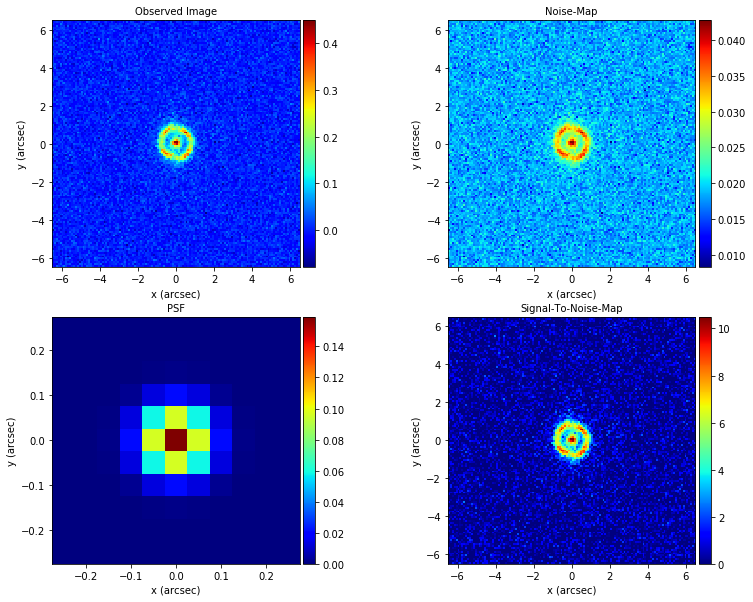

In [6]:
# Simulate the image and set it up.
image = simulate()

# When we plot it, the lens light's is clealy visible in the centre of the image
imaging_plotters.plot_image_subplot(image=image)

In [7]:
# Now lets fit it using a phase, noting that indeed the galaxy-model corresponds to the one above.

# Because we now have 18 non-linear parameters. the non-linear search takes a lot longer to run. On my laptop, this 
# phase took around an hour, which is a bit too long for you to wait if you want to go through these tutorials quickly. 
# Therefore, the results of this non-linear search (and future ones) are already included, allowing you to
# go through the tutorial as if you had actually run them.

# Nevertheless, you could try running it yourself (maybe over your lunch break?). All you need to do is change the 
# phase_name below, maybe to something like 'howtolens/3_realism_and_complexity_rerun'
phase = ph.LensSourcePlanePhase(lens_galaxies=dict(lens_galaxy=gm.GalaxyModel(light=lp.EllipticalSersic,
                                                                                mass=mp.EllipticalIsothermal)),
                                source_galaxies=dict(source_galaxy=gm.GalaxyModel(light=lp.EllipticalExponential)),
                                optimizer_class=nl.MultiNest,
                                phase_name='3_realism_and_complexity')


In [8]:
# Lets run the phase - note that, in Jupyter notebooks, all the MultiNest output is written to the cell. This might
# get pretty long, but I wouldn't worry about it for now as we'll address this in the pipelines tutorial.
results = phase.run(image)


DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalSersic
centre: (0.5603774043254706, -0.4178983010730489)
axis_ratio: 0.5404818612901716
phi: 130.18638356679045
intensity: 0.1809171322676056
effective_radius: 0.22536663940419452
sersic_index: 7.272823408540029
Mass Profiles:
EllipticalIsothermal
centre: (-0.08369287217672028, -0.09247069546963488)
axis_ratio: 0.22166020689146498
phi: 142.6066391549599
einstein_radius: 2.9751368794522035
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
EllipticalExponential
centre: (-0.7488125906866145, 1.324459993492742)
axis_ratio: 0.8158674163032305
phi: 78.96987335515287
intensity: 0.5193475404840734
effective_radius: 0.15957228653207756
sersic_index: 1.0]




In [5]:
# And lets look at the image.
fitting_plotters.plot_fitting_subplot(fit=results.fit)

NameError: name 'results' is not defined

In [ ]:
# Uh-oh. That image didn't look very good, did it? If we compare our inferred parameters to the actual values (in the
# simulations.py file) you'll see that we have, indeed, fitted the wrong model.
print(results)

In [ ]:
# Yep, we've inferred the wrong lens model. Or have we? Maybe you're thinking that this model provides an even higher 
# likelihood than the correct solution? Lets make absolutely sure it doesnt: (you've seen all this code below before,
# but I've put a few comments to remind you of whats happening)

# Create a lensing image to make the fit - the mask we used above was a 3" circle (we'll come back to this later)
mask = ma.Mask.circular(shape=image.shape, pixel_scale=image.pixel_scale, radius_mask_arcsec=3.0)
lensing_image = li.LensingImage(image=image, mask=mask)
imaging_plotters.plot_image(lensing_image.image)

# Make the tracer we use to simulate the image
lens_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 0.0), axis_ratio=0.9, phi=45.0, intensity=0.04,
                                                 effective_radius=0.5, sersic_index=3.5),
                       mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=0.8))

source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 0.0), axis_ratio=0.5, phi=90.0, intensity=0.03,
                                                   effective_radius=0.3, sersic_index=3.0))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=lensing_image.grids)


In [ ]:
# Now, lets fit the lensing image with the tracer and plot the fit. It looks a lot better than above, doesn't it?
fit = lensing_fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
fitting_plotters.plot_fitting_subplot(fit=results.fit)

In [ ]:
# Finally, just to be sure, lets compare the two likelihoods
print('Likelihood of Non-linear Search:')
print(results.fit.likelihood)
print('Likelihood of Correct Model:')
print(fit.likelihood)

# Well, there we have it, the input model has a much higher likelihood than the one our non-linear search inferred. 

In [ ]:
# Clearly, our non-linear search failed. So, what happened? Where did it all go wrong?

# I want you to think about 'complexity'. As we made our lens model more realistic, we also made it more complex. Our
# non-linear parameter space went from 7 dimensions to 18. This means there was a much larger 'volume' of parameter
# space to search. Maybe, therefore, our non-linear search got lost. It found some region of parameter space that it
# thought was the highest likelihood region and decided to focus the rest of its search there. But it was mistaken,
# there was infact  another region of parameter space with even higher likelihood solutions.

# This region - the one our non-linear search failed to locate - is called the global maximum likelihood region. At its
# core, lens modeling is all about learning how to get a non-linear search to find this region of parameter space,
# even when the lens model is extremely complex.

# Iif you did run the phase above yourself, you might of actually inferred the correct lens model. There is some 
# level of randomness in a non-linear search. This means that sometimes, it might get infer a locally maximal likelihood,
# and other times find the global maxima another. Nevertheless, as lens models become more complex, you'll quickly find
# yourself stuck with only in local maxima, unless you learn how to navigate parameter space better.

In [ ]:
# And with that, we're done. In the next exercise, we'll learn how to deal with our failures and begin thinking about
# how we might encourage a non-linear search to find the global-maximum likelihood. Before that, think about the
# following:

# 1) When you look at an image of a strong lens, do you get a sense of roughly what values certain lens model
#    parameters are?

# 2) The non-linear search failed because parameter space was too complex. Could we make it less complex, whilst still
#    keeping our lens model fairly realistic?

# 3) The source galaxy in this example had only 6 non-linear parameters. Real source galaxies may have multiple
#    components (e.g. a bar, disk, bulge, star-forming knot) and there may even be more than 1 source galaxy! Do
#    you think there is any hope of us navigating a parameter space if the source contributes 20+ parameters by itself?